In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import numpy as np
import pandas as pd
from stochastic_rnn import StochasticLSTM
from stochastic_module import StochasticSingleOutputModule
from train_utils import weight_coefficient, bias_coefficient, filter_parameters, train_model

In [2]:
from sklearn.metrics import roc_auc_score

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(100)

In [5]:
training_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Training.data", sep=',', dtype=np.float64)
testing_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Testing.data", sep=',', dtype=np.float64)

In [6]:
training_table.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X92,X93,X94,X95,X96,X97,X98,X99,X100,class
0,39.02,36.49,38.20,38.85,39.38,39.74,37.02,39.53,38.81,38.79,...,36.62,36.92,38.80,38.52,38.07,36.73,39.46,37.50,39.10,0.0
1,1.83,1.71,1.77,1.77,1.68,1.78,1.80,1.70,1.75,1.78,...,1.80,1.79,1.77,1.74,1.74,1.80,1.78,1.75,1.69,1.0
2,68177.69,66138.42,72981.88,74304.33,67549.66,69367.34,69169.41,73268.61,74465.84,72503.37,...,73438.88,71053.35,71112.62,74916.48,72571.58,66348.97,71063.72,67404.27,74920.24,1.0
3,44889.06,39191.86,40728.46,38576.36,45876.06,47034.00,46611.43,37668.32,40980.89,38466.15,...,42625.67,40684.20,46960.73,44546.80,45410.53,47139.44,43095.68,40888.34,39615.19,0.0
4,5.70,5.40,5.28,5.38,5.27,5.61,6.00,5.38,5.34,5.87,...,5.17,5.67,5.60,5.94,5.73,5.22,5.30,5.73,5.91,0.0


In [7]:
dim = 1
seq_length = 100
DROP = 0.5
ls = 1e-2
tau = 1

In [8]:
def scale_inputs(x_inputs):
    median = np.median(x_inputs, axis=1).reshape(-1, 1)
    shifted_x = x_inputs - median
    scale = np.abs(shifted_x).max(axis=1).reshape(-1, 1)
    return shifted_x / scale

In [9]:
x_train = scale_inputs(training_table.drop("class", axis=1).values)
y_train = training_table["class"].values
x_test = scale_inputs(testing_table.drop("class", axis=1).values)
y_test = testing_table["class"].values

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

N = len(y_train)

train_dl = torch.utils.data.DataLoader(
        [(x_train[i], y_train[i]) for i in range(len(y_train))],
        batch_size=10,
        num_workers=2,
        shuffle=True
)

def format_input(input_batch):
    return input_batch.transpose(1, 0).reshape(seq_length, -1, dim)

In [10]:
class Net(StochasticSingleOutputModule):
    def __init__(self):
        super(Net, self).__init__(sample_size=10)
        self.rnn = StochasticLSTM(1, 10, DROP)
        self.fc = nn.Linear(10, 1)
    
    def forward(self, x: torch.Tensor):
        out, _ = self.rnn(x)
        out = torch.tanh(out[-1])
        out = self.fc(out)
        return out

In [11]:
net = Net().double()
criterion = nn.BCEWithLogitsLoss()

M = filter_parameters(net.named_parameters(), "rnn", "weight")
m = filter_parameters(net.named_parameters(), "rnn", "bias")
other_params = filter_parameters(net.named_parameters(), "fc", "")

parameters = [
    {"params": M, "weight_decay": weight_coefficient(ls, tau, DROP, N)}, # dropout rnn weight
    {"params": m, "weight_decay": bias_coefficient(ls, tau, N)}, # dropout rnn bias
    {"params": other_params} # other parameters
]
optimizer = optim.Adam(parameters, lr=1e-3)

In [21]:
train_model(net, train_dl, criterion, optimizer, 10)

[1,    60] loss: 0.664708
[2,    60] loss: 0.633737
[3,    60] loss: 0.623760
[4,    60] loss: 0.609314
[5,    60] loss: 0.553160
[6,    60] loss: 0.577875
[7,    60] loss: 0.507131
[8,    60] loss: 0.538138
[9,    60] loss: 0.467175
[10,    60] loss: 0.450661
Finish training


In [13]:
def prediction(props):
    return props.mean(axis=0)

def aleatoric_uncertainty(props):
    aleatoric = props * (1-props)
    aleatoric = aleatoric.mean(axis=0)
    return aleatoric

def epistemic_uncertainty(props):
    return torch.var(props, dim=0, unbiased=False)

def uncertainty(props):
    return aleatoric_uncertainty(props) + epistemic_uncertainty(props)

In [22]:
net.eval()
with torch.no_grad():
    outputs = net(torch.tensor(x_test.reshape(606, 100, 1).swapaxes(1, 0)))
    outputs = torch.sigmoid(outputs)
    outputs = outputs.flatten(1)
    uncertainties = uncertainty(outputs)
    uncertainties = uncertainties.data.numpy()
    predictions = prediction(outputs)
    predictions = predictions.data.numpy()

In [23]:
roc_auc_score(y_test, predictions)

0.8646302005599555

In [24]:
A = aleatoric_uncertainty(outputs).data.numpy()
E = epistemic_uncertainty(outputs).data.numpy()

In [25]:
for i in range(10):
    print("Entry %3i: label (%.0f), prediction (%.4f), uncertainty (%.4f), aleatoric (%.6f), epistemic (%.6f)" % (i, y_test[i], predictions[i], uncertainties[i], A[i], E[i]))

Entry   0: label (1), prediction (0.7047), uncertainty (0.2081), aleatoric (0.199429), epistemic (0.008673)
Entry   1: label (0), prediction (0.1818), uncertainty (0.1487), aleatoric (0.144611), epistemic (0.004106)
Entry   2: label (0), prediction (0.2660), uncertainty (0.1952), aleatoric (0.185430), epistemic (0.009812)
Entry   3: label (1), prediction (0.8449), uncertainty (0.1310), aleatoric (0.129610), epistemic (0.001436)
Entry   4: label (1), prediction (0.3345), uncertainty (0.2226), aleatoric (0.205614), epistemic (0.017012)
Entry   5: label (0), prediction (0.2069), uncertainty (0.1641), aleatoric (0.158795), epistemic (0.005323)
Entry   6: label (0), prediction (0.1963), uncertainty (0.1578), aleatoric (0.152005), epistemic (0.005766)
Entry   7: label (0), prediction (0.2876), uncertainty (0.2049), aleatoric (0.191033), epistemic (0.013862)
Entry   8: label (0), prediction (0.2169), uncertainty (0.1699), aleatoric (0.165927), epistemic (0.003948)
Entry   9: label (1), predic

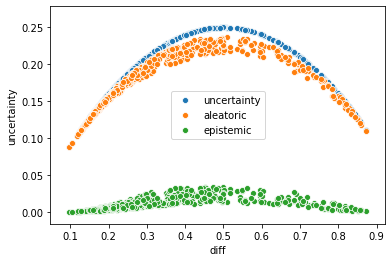

In [40]:
dist = np.abs(y_test - predictions)
sns.scatterplot(x=dist, y=uncertainties)
sns.scatterplot(x=dist, y=A)
sns.scatterplot(x=dist, y=E)
plt.xlabel("diff")
plt.ylabel("uncertainty")
plt.legend(labels=['uncertainty', 'aleatoric', 'epistemic'])

In [44]:
predictions.shape

(606,)